In [1]:
import pandas as pd
import numpy as np
import math
import os
from datetime import datetime
from os.path import join as pj
from copy import deepcopy
import matplotlib.pyplot as plt
import torch

month_map = dict(zip(['January', 'February', 'March', 'April', 'May', 'June',
     'July', 'August', 'September', 'October', 'November', 'December'],
     list(range(1,13))))
parse_date = lambda x: datetime.strptime(x , '%Y-%m-%d')
future_cols =['adr', 'is_canceled', 'reservation_status_date', 'reservation_status']
arrival_date_cols =['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'] 


root = 'dataset'
train_x_path = pj(root ,'train.csv')
train_y_path = pj(root , 'train_label.csv')
test_x_path = pj(root , 'test.csv')
test_y_path = pj(root,  'test_nolabel.csv')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Feature selection

Parts:
- Main table (with all guessed future columns)
- **Target**: is_cancel 
- **Target**: adr

In [ ]:
### train

In [2]:
def preprocessing(df, drop_future = False, Test=False):
    df = df.replace({'arrival_date_month' : month_map})
    df['arrival_date'] = df[arrival_date_cols].astype(str).agg('-'.join, axis=1)
    df['arrival_date'] = df['arrival_date'].apply(parse_date)
    df = df.drop(arrival_date_cols, axis = 1)
    
    if not Test:
        df['reservation_status_date']=df['reservation_status_date'].apply(parse_date)
        
    if drop_future:
        for future in future_cols:
            if future in df.columns:
                df = df.drop([future] ,axis=1)
    return df

def get_feature(df , adr = False ):
    
    key = ['arrival_date']
    feat_level=[
        'hotel', 
        'meal',
        'country',
        'market_segment',
        'distribution_channel',
        'reserved_room_type',
        'assigned_room_type',
        'deposit_type',
        'customer_type']

    feat_num=['lead_time',
        'stays_in_weekend_nights',
        'stays_in_week_nights',
        'adults',
        'children',
        'babies', 
        'is_repeated_guest',
        'previous_cancellations',
        'previous_bookings_not_canceled',
        'booking_changes',
        'agent',
        'company', 
        'days_in_waiting_list',
        'required_car_parking_spaces',
        'total_of_special_requests']
    
    df[['children', 'agent' , 'company']] = df[['children', 'agent' , 'company']].fillna(0.0)
    df_proce = pd.get_dummies(df[feat_num + feat_level])
    df_proce = pd.concat([df[key], df_proce] ,axis=1)

    if adr:
        return df_proce , df['adr']
    return df_proce

def agg_by_date(df):
    df = df.groupby(['arrival_date']).sum()
    return df 

def data_augmentor(df, y, times = 10, sigma=0.1):
    df_g = deepcopy(df)
    y_g = deepcopy(y)
    print('original shape: ', df_g.shape)
    for _ in range(times):
        df_noise = np.random.normal(0,sigma, df.shape)
        df_g = pd.concat([df_g , df.add(df_noise, axis =1)], axis =0)
        y_g = pd.concat([y_g , deepcopy(y)], axis =0)
    print('augmented shape:' , df_g.shape)
    return df_g , y_g
# def agg(df , method='sum'):
#     if method=='sum':
#         df.groupby(['arrival_date']).sum()
#     elif method=='mean':
        

In [3]:
df_x = pd.read_csv(train_x_path)
df_y = pd.read_csv(train_y_path)

df_x_t = pd.read_csv(test_x_path)
df_y_t = pd.read_csv(test_y_path)
df_x = preprocessing(df_x)
df_y['arrival_date'] = df_y['arrival_date'].apply(parse_date)


df_x_t = preprocessing(df_x_t, Test = True)
df_y_t['arrival_date'] = df_y_t['arrival_date'].apply(parse_date)

## Sum( adr ) by date

- **valid**: no neg. date
- **invalid**: with neg. date

In [97]:
invalid_x , valid_x = deepcopy(df_x),deepcopy(df_x)
valid_x = valid_x.loc[valid_x['is_canceled']==0,:].reset_index(drop=True)
# valid_x['adr'] = abs(valid_x['adr'])

In [98]:
v_adr = valid_x.groupby('arrival_date').sum()[['adr']]
inv_adr = invalid_x.groupby('arrival_date').sum()[['adr']]

# v_adr = valid_x.groupby('arrival_date').mean()[['adr']]
# inv_adr = invalid_x.groupby('arrival_date').mean()[['adr']]


<AxesSubplot:>

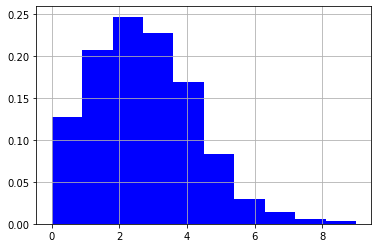

In [99]:
v_normal = v_adr['adr']
v_normal = 9*(v_normal - v_normal.min())/\
            (v_normal.max() - v_normal.min())
v_normal.hist(density= True,bins=10,cumulative=0,color='b')


<AxesSubplot:>

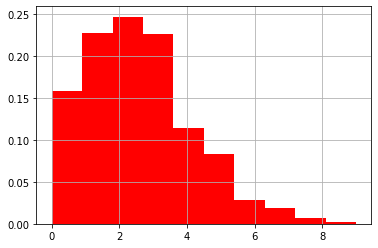

In [100]:
inv_normal = inv_adr['adr']
inv_normal = 9*(inv_normal - inv_normal.min())/\
            (inv_normal.max() - inv_normal.min())

inv_normal.hist(density= True,bins=10,cumulative=0,color='r')

## Sum( adr $\times$ date_range) by date

- **valid**: no neg. date
- **invalid**: with neg. date

In [316]:
invalid_x , valid_x = deepcopy(df_x),deepcopy(df_x)
valid_x = valid_x.loc[valid_x['is_canceled']==0,:].reset_index(drop=True)
# valid_x['adr'] = abs(valid_x['adr'])
valid_x['adr'] = valid_x['adr'].apply(lambda x: max(0,x))



date_range_v = (valid_x['reservation_status_date']-valid_x['arrival_date'])\
            .apply(lambda x : x.days)
date_range_inv = (invalid_x['reservation_status_date']-invalid_x['arrival_date'])\
            .apply(lambda x : x.days)
valid_x['date_range']=date_range_v
valid_x['date_range']=valid_x['date_range'].apply(lambda x: 0 if x<=0 else x)
valid_x['sum_adr'] = valid_x['date_range']*valid_x['adr']
# valid_x['sum_adr'] = valid_x[['date_range','adr']]\
#                         .apply(lambda x: x.date_range*x.adr if x.date_range>0 else \
#                               0 if x.adr<=0 else x.adr, axis = 1)

invalid_x['date_range']=date_range_inv
invalid_x['sum_adr'] = invalid_x['date_range']*invalid_x['adr']

In [317]:
v_sumadr = valid_x.groupby('arrival_date').sum()[['sum_adr']]
inv_sumadr = invalid_x.groupby('arrival_date').sum()[['sum_adr']]
# v_adr = valid_x.groupby('arrival_date').mean()[['adr']]
# inv_adr = invalid_x.groupby('arrival_date').mean()[['adr']]


<AxesSubplot:>

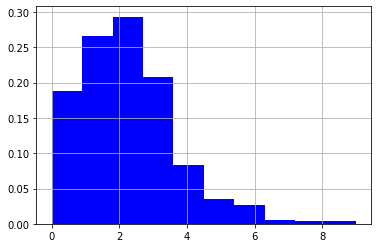

In [318]:
vsum_normal = v_sumadr['sum_adr']
vsum_normal = 9*(vsum_normal - vsum_normal.min())/\
            (vsum_normal.max() - vsum_normal.min())
vsum_normal.hist(density= True,bins=10,cumulative=0,color='b')


<AxesSubplot:>

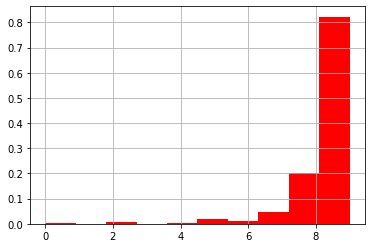

In [319]:
invsum_normal = inv_sumadr['sum_adr']
invsum_normal = 9*(invsum_normal - invsum_normal.min())/\
            (invsum_normal.max() - invsum_normal.min())

invsum_normal.hist(density= True,bins=10,cumulative=0,color='r')

## True $x$ label distribuion

<AxesSubplot:>

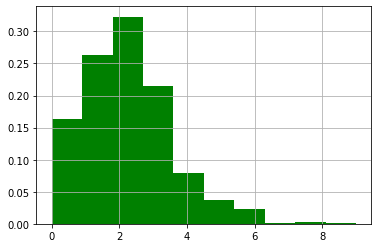

In [320]:
df_y['label'].hist(density=True , bins=10 ,cumulative=0 , color='g')

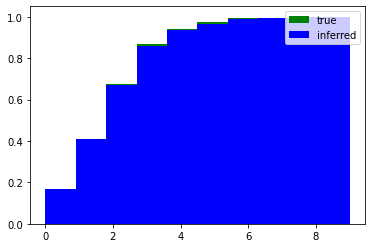

In [321]:
infer_label = vsum_normal.values
true_label = df_y['label']
plt.hist(true_label , 
        density=True,
         cumulative=1 ,
         bins=10,
         color='green',
        label='true')
plt.hist(infer_label ,
         density=True,
         cumulative=1 ,
         bins=10,
         color='blue',
        label='inferred')


plt.legend(loc='upper right')
plt.show()

In [322]:
abs(infer_label - true_label).sum()/len(infer_label)

0.3123135872507655

In [323]:
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score , f1_score , recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.preprocessing import StandardScaler as sc
from sklearn.multiclass import OneVsRestClassifier as OVR

## From normalized_adr to label

In [324]:
x, y = infer_label, true_label.values
x, y = x.reshape(-1 ,1) , y.reshape(-1,1)
test_size = 300 # from 640

### Linear Regression

In [325]:
model_lr = LinearRegression(normalize=False)
model_lr = OVR(model_lr)
model_lr.fit(x[:test_size,:] , y[:test_size,:])


OneVsRestClassifier(estimator=LinearRegression())

In [266]:
y_pred = model_lr.predict(x[test_size:,:])
mae(y[test_size:,:] , y_pred)

0.861764705882353

### SVR

In [326]:
model_svr = SVC(C=10)
# model_svr = OVR(model_svr)
model_svr.fit(x[:test_size,:] , y[:test_size,:].flatten())


SVC(C=10)

In [327]:
y_pred = model_lr.predict(x[test_size:,:])
mae(y[test_size:,:].flatten() , y_pred)

0.861764705882353

### LGB

In [328]:
from lightgbm import LGBMClassifier

model_lgb = LGBMClassifier(num_class =10 ,
                           objective='multiclass',
                           metric='multi_logloss')
model_lgb.fit(x[:test_size,:] , y[:test_size,:].flatten())

LGBMClassifier(metric='multi_logloss', num_class=10, objective='multiclass')

In [329]:
y_pred = model_lgb.predict(x[test_size:,:])
mae(y[test_size:,:].flatten() , y_pred)

0.08823529411764706

In [72]:
import joblib
# from sklearn.model_selection import GridSearchCV 

# parameters ={
#     'max_leaf': [100 , 200, 300 ,400 , 600],
#     'max_depth': [2, 5 ,10 , 15, 20,  35],
#     'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
#     'feature_fraction': [0.6, 0.7, 0.8, 0.95],
#     'bagging_fraction': [0.6, 0.7, 0.8, 0.95],
#     'bagging_freq': [2, 4, 6, 8],
#     'lambda_l1': [0.1, 0.4, 0.6],
#     'lambda_l2': [10, 15, 35],
#     'cat_smooth': [1, 10, 15, 20, 35],
#     }
# gs = GridSearchCV(model_lgb , 
#                   param_grid =parameters , 
#                   n_jobs = 20)
# gs.fit(x[:test_size,:] , y[:test_size,:].flatten())
# gs.best_params_
gs_ = joblib.load("gs_model_yy")

In [253]:
model =  gs_.estimator
params = gs_.best_params_

In [254]:
# model
params

{'bagging_fraction': 0.95,
 'bagging_freq': 2,
 'cat_smooth': 1,
 'feature_fraction': 0.6,
 'lambda_l1': 0.1,
 'lambda_l2': 10,
 'learning_rate': 0.15,
 'max_depth': 2,
 'max_leaf': 100}

In [255]:
model.set_params(**params)

LGBMClassifier(bagging_fraction=0.95, bagging_freq=2, cat_smooth=1,
               feature_fraction=0.6, lambda_l1=0.1, lambda_l2=10,
               learning_rate=0.15, max_depth=2, max_leaf=100,
               metric='multi_logloss', num_class=10, objective='multiclass')

In [256]:
model.fit(x[:test_size,:] , y[:test_size,:].flatten())

[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] num_leaves is set=31, max_leaf=100 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


LGBMClassifier(bagging_fraction=0.95, bagging_freq=2, cat_smooth=1,
               feature_fraction=0.6, lambda_l1=0.1, lambda_l2=10,
               learning_rate=0.15, max_depth=2, max_leaf=100,
               metric='multi_logloss', num_class=10, objective='multiclass')

In [257]:
y_pred = model.predict(x[test_size:,:])
mae(y[test_size:,:].flatten() , y_pred)

0.24259259259259258

In [295]:
import pickle 
with open('yy.pickle', 'wb') as f:
    pickle.dump([x[:test_size,:] , y[:test_size,:].flatten()] ,f)
    

In [296]:
with open('yy.pickle' ,'rb') as f:
    x_train , y_train  =  pickle.load(f)

In [ ]:
y_pred = model_lgb.predict(x[test_size:,:])
mae(y[test_size:,:].flatten() , y_pred)

## Remaining Feature for ADR

In [179]:
remain_cols=[\
            'lead_time',
            'stays_in_weekend_nights', 
            'stays_in_week_nights',
            'adults', 
            'children',
            'babies', 
#             'meal',
#             'country',
#             'market_segment',
#             'distribution_channel',
            'is_repeated_guest', 
            'previous_cancellations',
            'previous_bookings_not_canceled',
#             'reserved_room_type',
#             'assigned_room_type', 
            'booking_changes',
#             'deposit_type',
            'agent',
            'company',
            'days_in_waiting_list',
#             'customer_type',
            'required_car_parking_spaces', 
            'total_of_special_requests',
              ]


In [171]:
valid_x_sum = valid_x.groupby('arrival_date').sum()

In [176]:
valid_x_sum.columns

Index(['ID', 'is_canceled', 'lead_time', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'date_range', 'sum_adr'],
      dtype='object')

array([[<AxesSubplot:title={'center':'lead_time'}>,
        <AxesSubplot:title={'center':'stays_in_weekend_nights'}>],
       [<AxesSubplot:title={'center':'stays_in_week_nights'}>,
        <AxesSubplot:title={'center':'adults'}>]], dtype=object)

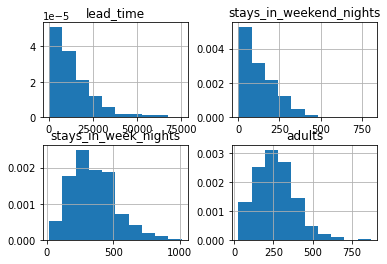

In [183]:
valid_x_sum[remain_cols[:4]].hist(bins=10,density=True)

array([[<AxesSubplot:title={'center':'children'}>,
        <AxesSubplot:title={'center':'babies'}>],
       [<AxesSubplot:title={'center':'is_repeated_guest'}>,
        <AxesSubplot:title={'center':'previous_cancellations'}>]],
      dtype=object)

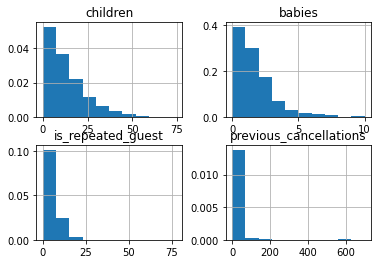

In [184]:
valid_x_sum[remain_cols[4:8]].hist(bins=10,density=True)

array([[<AxesSubplot:title={'center':'previous_bookings_not_canceled'}>,
        <AxesSubplot:title={'center':'booking_changes'}>],
       [<AxesSubplot:title={'center':'agent'}>,
        <AxesSubplot:title={'center':'company'}>]], dtype=object)

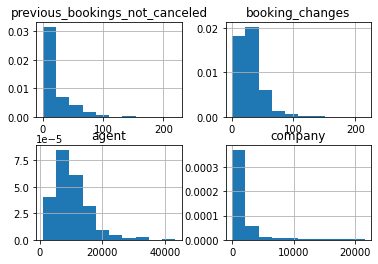

In [185]:
valid_x_sum[remain_cols[8:12]].hist(bins=10,density=True)

array([[<AxesSubplot:title={'center':'days_in_waiting_list'}>,
        <AxesSubplot:title={'center':'required_car_parking_spaces'}>],
       [<AxesSubplot:title={'center':'total_of_special_requests'}>,
        <AxesSubplot:>]], dtype=object)

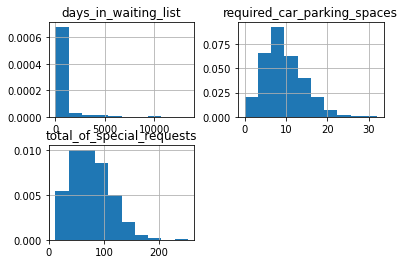

In [186]:
valid_x_sum[remain_cols[12:]].hist(bins=10,density=True)

In [187]:
remain_cols

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [191]:
def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v


valid_x_sum['lead_time'].corr(true_label, method='pearson')

nan

In [313]:
remain_x_y = deepcopy(valid_x_sum[remain_cols])
remain_x_y['label']=true_label.values
remain_x_y = remain_x_y[['label']+remain_cols]
# .corr(method='pearson')


In [314]:
((remain_x_y.corr(method='pearson')**2)**.5)\
            .sort_values('label',ascending=False)

,label,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
label,1.000000,0.513087,0.633663,0.556352,0.637922,0.624413,0.347326,0.181930,0.012054,0.120508,0.409913,0.432488,0.076464,0.097123,0.458513,0.626447
adults,0.637922,0.809737,0.524372,0.826537,1.000000,0.439049,0.185092,0.016638,0.116263,0.039203,0.549339,0.624377,0.155262,0.271310,0.480812,0.636411
stays_in_weekend_nights,0.633663,0.342950,1.000000,0.242447,0.524372,0.375137,0.275103,0.186849,0.048385,0.148287,0.259763,0.442653,0.111548,0.028835,0.272680,0.458020
total_of_special_requests,0.626447,0.464766,0.458020,0.537144,0.636411,0.600007,0.270889,0.030378,0.112144,0.029098,0.423111,0.490732,0.001201,0.068228,0.485960,1.000000
children,0.624413,0.274927,0.375137,0.348007,0.439049,1.000000,0.340986,0.153325,0.101387,0.104211,0.342271,0.338233,0.108282,0.013109,0.487390,0.600007
stays_in_week_nights,0.556352,0.752619,0.242447,1.000000,0.826537,0.348007,0.112213,0.084009,0.105784,0.102751,0.557976,0.564633,0.240636,0.287191,0.431735,0.537144
lead_time,0.513087,1.000000,0.342950,0.752619,0.809737,0.274927,0.094193,0.083254,0.128481,0.088290,0.507240,0.449613,0.146675,0.323660,0.307095,0.464766
required_car_parking_spaces,0.458513,0.307095,0.272680,0.431735,0.480812,0.487390,0.225466,0.006595,0.086548,0.066465,0.383784,0.401743,0.151457,0.094161,1.000000,0.485960
agent,0.432488,0.449613,0.442653,0.564633,0.624377,0.338233,0.151318,0.014482,0.017619,0.005433,0.385253,1.000000,0.010146,0.121016,0.401743,0.490732
booking_changes,0.409913,0.507240,0.259763,0.557976,0.549339,0.342271,0.130197,0.009156,0.056233,0.044632,1.000000,0.385253,0.331493,0.141522,0.383784,0.423111


In [315]:
((remain_x_y.corr(method='pearson')**1)**1)\
            .sort_values('label',ascending=False)

,label,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
label,1.000000,0.513087,0.633663,0.556352,0.637922,0.624413,0.347326,-0.181930,-0.012054,-0.120508,0.409913,0.432488,-0.076464,0.097123,0.458513,0.626447
adults,0.637922,0.809737,0.524372,0.826537,1.000000,0.439049,0.185092,-0.016638,0.116263,-0.039203,0.549339,0.624377,0.155262,0.271310,0.480812,0.636411
stays_in_weekend_nights,0.633663,0.342950,1.000000,0.242447,0.524372,0.375137,0.275103,-0.186849,0.048385,-0.148287,0.259763,0.442653,-0.111548,0.028835,0.272680,0.458020
total_of_special_requests,0.626447,0.464766,0.458020,0.537144,0.636411,0.600007,0.270889,-0.030378,-0.112144,0.029098,0.423111,0.490732,-0.001201,0.068228,0.485960,1.000000
children,0.624413,0.274927,0.375137,0.348007,0.439049,1.000000,0.340986,-0.153325,-0.101387,-0.104211,0.342271,0.338233,-0.108282,0.013109,0.487390,0.600007
stays_in_week_nights,0.556352,0.752619,0.242447,1.000000,0.826537,0.348007,0.112213,0.084009,0.105784,0.102751,0.557976,0.564633,0.240636,0.287191,0.431735,0.537144
lead_time,0.513087,1.000000,0.342950,0.752619,0.809737,0.274927,0.094193,-0.083254,0.128481,-0.088290,0.507240,0.449613,0.146675,0.323660,0.307095,0.464766
required_car_parking_spaces,0.458513,0.307095,0.272680,0.431735,0.480812,0.487390,0.225466,0.006595,-0.086548,0.066465,0.383784,0.401743,0.151457,0.094161,1.000000,0.485960
agent,0.432488,0.449613,0.442653,0.564633,0.624377,0.338233,0.151318,0.014482,0.017619,0.005433,0.385253,1.000000,0.010146,0.121016,0.401743,0.490732
booking_changes,0.409913,0.507240,0.259763,0.557976,0.549339,0.342271,0.130197,0.009156,-0.056233,0.044632,1.000000,0.385253,0.331493,0.141522,0.383784,0.423111


In [317]:
related_cols= [ 
        'adults',
        'stays_in_weekend_nights',
        'total_of_special_requests',
        'children',
        'stays_in_week_nights',
        'lead_time',
        'required_car_parking_spaces',
        'agent',
        'booking_changes',
        'babies'] 
related_x = remain_x_y[related_cols]

## Remaining feature for Stay_days

In [395]:
valid_x = deepcopy(df_x)
# valid_x = valid_x.loc[valid_x['is_canceled']==0,:].reset_index(drop=True)
# valid_x['adr'] = abs(valid_x['adr'])
# valid_x['adr'] = valid_x['adr'].apply(lambda x: max(0,x))

date_range_v = (valid_x['reservation_status_date']-valid_x['arrival_date'])\
            .apply(lambda x : x.days)
valid_x['date_range']=date_range_v
# valid_x['date_range']=valid_x['date_range'].apply(lambda x: 0 if x<=0 else x)
valid_x['sum_adr'] = valid_x['date_range']*valid_x['adr']


In [396]:
date_related_cols = [ 
                    'date_range',
                    'hotel', 
#                     'is_canceled',
                    'lead_time',
                    'arrival_date_week_number',
                    'stays_in_weekend_nights', 
                    'stays_in_week_nights',
                    'adults',
                    'children',
                    'babies', 
                    'meal',
                    'country',
                    'market_segment',
                    'distribution_channel',
                    'is_repeated_guest', 
                    'previous_cancellations',
                    'previous_bookings_not_canceled', 
                    'reserved_room_type',
                    'assigned_room_type', 
                    'booking_changes', 
                    'deposit_type',
                    'agent',
                    'company', 
                    'days_in_waiting_list', 
                    'customer_type', 
#                     'adr',
                    'required_car_parking_spaces',
                    'total_of_special_requests',
#                     'reservation_status',
#                     'reservation_status_date',
                    'arrival_date', 
#                     'sum_adr'
]

In [397]:
date_related = valid_x[date_related_cols]

((date_related.corr(method='pearson')**2)**.5)\
            .sort_values('date_range',ascending=False)

,date_range,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
date_range,1.000000,0.619249,0.070563,0.080944,0.009283,0.071434,0.036163,0.023896,0.020217,0.140024,0.036299,0.113867,0.125809,0.005578,0.050100,0.114044,0.210708
lead_time,0.619249,1.000000,0.155992,0.057351,0.145017,0.114516,0.060137,0.025167,0.117214,0.111519,0.071374,0.016268,0.125697,0.151244,0.205704,0.117076,0.137366
total_of_special_requests,0.210708,0.137366,0.031282,0.075139,0.068818,0.122553,0.089923,0.104010,0.001424,0.056001,0.029086,0.040245,0.043028,0.085697,0.088337,0.083928,1.000000
previous_cancellations,0.140024,0.111519,0.029807,0.009460,0.011113,0.000663,0.025355,0.008460,0.073088,1.000000,0.128712,0.030735,0.011313,0.173977,0.002727,0.023007,0.056001
agent,0.125809,0.125697,0.031241,0.126642,0.173179,0.039348,0.030731,0.036703,0.024725,0.011313,0.021735,0.068828,1.000000,0.430367,0.062414,0.186292,0.043028
required_car_parking_spaces,0.114044,0.117076,0.002775,0.018331,0.026595,0.016953,0.063268,0.032005,0.068502,0.023007,0.043570,0.060834,0.186292,0.010881,0.035900,1.000000,0.083928
booking_changes,0.113867,0.016268,0.004075,0.073775,0.103896,0.051519,0.048037,0.080451,0.009094,0.030735,0.013024,1.000000,0.068828,0.129543,0.013164,0.060834,0.040245
stays_in_weekend_nights,0.080944,0.057351,0.022775,1.000000,0.517161,0.089761,0.040299,0.017438,0.092898,0.009460,0.041479,0.073775,0.126642,0.097765,0.058431,0.018331,0.075139
adults,0.071434,0.114516,0.029081,0.089761,0.084698,1.000000,0.030126,0.019994,0.137987,0.000663,0.104113,0.051519,0.039348,0.219433,0.003905,0.016953,0.122553
arrival_date_week_number,0.070563,0.155992,1.000000,0.022775,0.015237,0.029081,0.000639,0.009022,0.036474,0.029807,0.026496,0.004075,0.031241,0.057809,0.015575,0.002775,0.031282


In [404]:
top_related_cols = ['lead_time',
                    'total_of_special_requests',
                    'previous_cancellations',
                    'agent',
                    'required_car_parking_spaces',
                    'booking_changes']

In [402]:
((date_related.corr(method='pearson')))\
            .sort_values('date_range',ascending=False)

,date_range,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
date_range,1.000000,-0.619249,-0.070563,0.080944,0.009283,-0.071434,0.036163,0.023896,0.020217,-0.140024,0.036299,0.113867,0.125809,0.005578,-0.050100,0.114044,0.210708
total_of_special_requests,0.210708,-0.137366,0.031282,0.075139,0.068818,0.122553,0.089923,0.104010,0.001424,-0.056001,0.029086,0.040245,0.043028,-0.085697,-0.088337,0.083928,1.000000
agent,0.125809,-0.125697,-0.031241,0.126642,0.173179,-0.039348,0.030731,0.036703,0.024725,-0.011313,0.021735,0.068828,1.000000,0.430367,-0.062414,0.186292,0.043028
required_car_parking_spaces,0.114044,-0.117076,-0.002775,-0.018331,-0.026595,0.016953,0.063268,0.032005,0.068502,-0.023007,0.043570,0.060834,0.186292,-0.010881,-0.035900,1.000000,0.083928
booking_changes,0.113867,-0.016268,0.004075,0.073775,0.103896,-0.051519,0.048037,0.080451,0.009094,-0.030735,0.013024,1.000000,0.068828,0.129543,-0.013164,0.060834,0.040245
stays_in_weekend_nights,0.080944,0.057351,0.022775,1.000000,0.517161,0.089761,0.040299,0.017438,-0.092898,-0.009460,-0.041479,0.073775,0.126642,0.097765,-0.058431,-0.018331,0.075139
previous_bookings_not_canceled,0.036299,-0.071374,-0.026496,-0.041479,-0.050100,-0.104113,-0.020664,-0.006843,0.413832,0.128712,1.000000,0.013024,0.021735,-0.203653,-0.011044,0.043570,0.029086
children,0.036163,-0.060137,-0.000639,0.040299,0.036938,0.030126,1.000000,0.027086,-0.031518,-0.025355,-0.020664,0.048037,0.030731,0.035497,-0.034799,0.063268,0.089923
babies,0.023896,-0.025167,0.009022,0.017438,0.016841,0.019994,0.027086,1.000000,-0.009471,-0.008460,-0.006843,0.080451,0.036703,0.024929,-0.012222,0.032005,0.104010
is_repeated_guest,0.020217,-0.117214,-0.036474,-0.092898,-0.103593,-0.137987,-0.031518,-0.009471,1.000000,0.073088,0.413832,0.009094,0.024725,-0.237287,-0.025981,0.068502,0.001424


In [452]:
date_related.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91531 entries, 0 to 91530
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date_range                      91531 non-null  int64         
 1   hotel                           91531 non-null  object        
 2   lead_time                       91531 non-null  int64         
 3   arrival_date_week_number        91531 non-null  int64         
 4   stays_in_weekend_nights         91531 non-null  int64         
 5   stays_in_week_nights            91531 non-null  int64         
 6   adults                          91531 non-null  int64         
 7   children                        91527 non-null  float64       
 8   babies                          91531 non-null  int64         
 9   meal                            91531 non-null  object        
 10  country                         91063 non-null  object        
 11  ma

In [442]:
date_x , date_y = date_related[top_related_cols],\
                        date_related['date_range']
date_y = date_y.apply(lambda x: 0 if x<=0 else 1)
d_test_size= 45000
d_x_val , d_y_val = date_x[:d_test_size] , date_y[:d_test_size]
d_x_train , d_y_train = date_x[d_test_size:] , date_y[d_test_size:]

In [443]:
# lgb_date = LGBMClassifier( objective='regression')
lgb_date = LGBMClassifier(objective='binary',
                          metric='cross-entropy')

In [444]:
lgb_date.fit(d_x_train , d_y_train)

LGBMClassifier(metric='cross-entropy', objective='binary')

In [445]:
d_y_pred = lgb_date.predict(d_x_val)
mae(d_y_val , d_y_pred)

0.22617777777777778

In [446]:
nonzero_index =d_y_val>0
mae(d_y_val[nonzero_index] , d_y_pred[nonzero_index])

0.1475085134477726

In [447]:
date_y_pred = lgb_date.predict(date_x)

In [448]:
mae(date_y , date_y_pred)

0.20140717352590926

In [449]:
from sklearn.preprocessing import LabelEncoder as LE
le = LE()
